In [1]:
import sys
sys.path.append('..')

from dataset import ModisDataset
import pandas as pd
import geopandas as gpd
#!pip install contextily
import contextily as ctx
import matplotlib.pyplot as plt
import os
import torch
from model import Model, restore

tumblack = "#000000"
tumblue = "#0065bd"
tumorange = "#e37222"
tumbluelight = "#64a0c8"
tumgray = "#999999"
tumlightgray = "#dad7cb"
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
def get_idx(df, fid):
    return np.where(test.index == fid)[0]

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

def load_gdf(fold):
    dataset = ModisDataset(region="germany",
                           fold=fold,
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=False,
                           filter_date=(None,None),
                           smooth=None)
    
    gdf = gpd.GeoDataFrame(dataset.meta, geometry=gpd.points_from_xy(dataset.meta.x, dataset.meta.y),crs=4326).to_crs(epsg=3857)
    gdf["fold"] = fold
    return gdf, dataset

train, traindataset = load_gdf('train')
validate, validatedataset = load_gdf('validate')
test, testdataset = load_gdf('test')

points = pd.concat([train,validate,test])

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz


/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz


/home/marc/miniconda3/envs/igarss2020/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


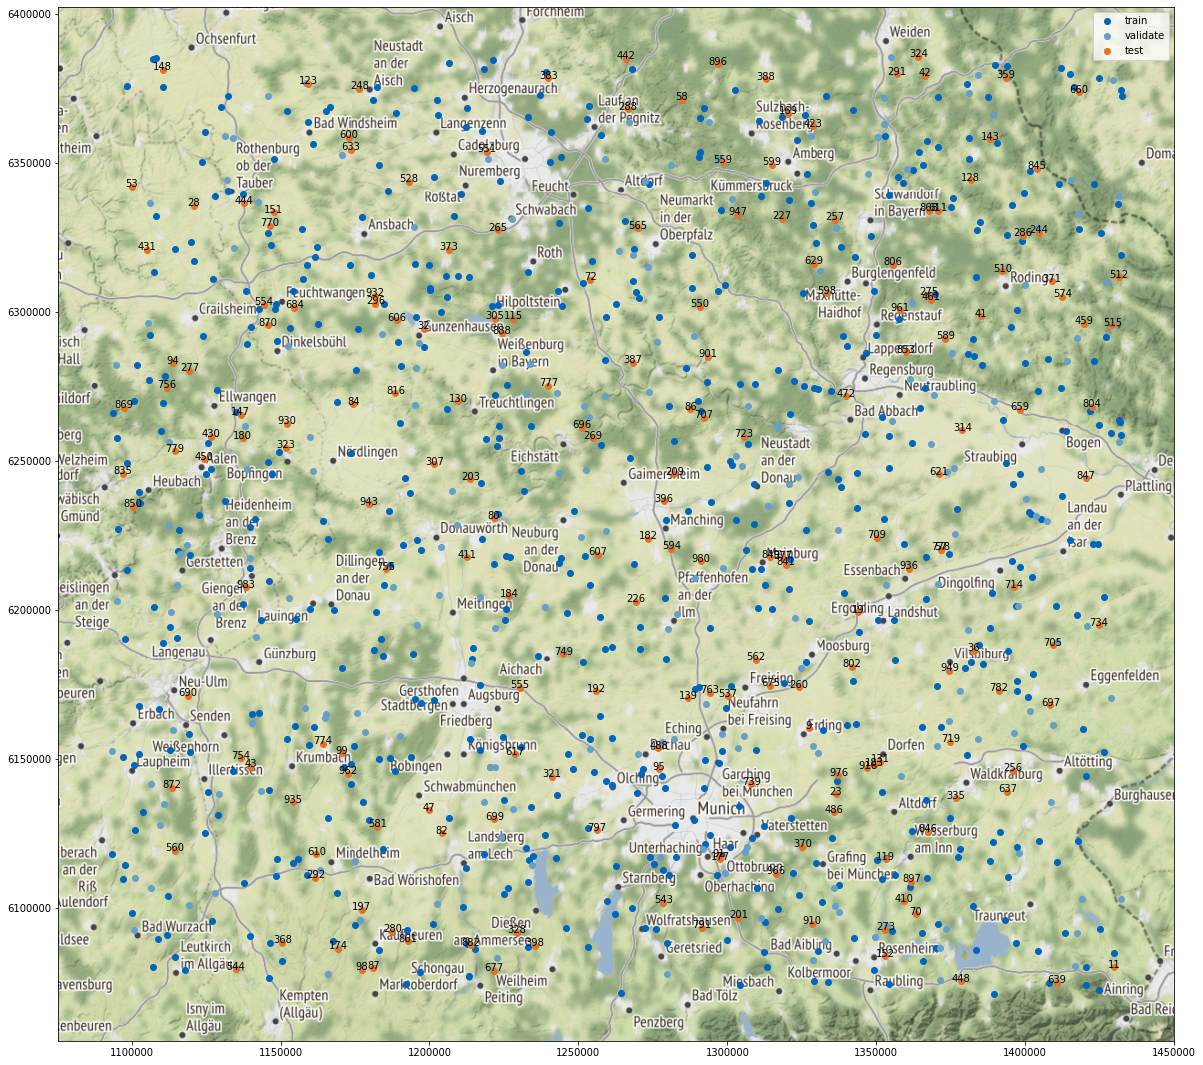

In [2]:
fix, ax = plt.subplots(figsize=(20,20))

ax = train.plot(color=tumblue, ax=ax)
ax = validate.plot(color=tumbluelight, ax=ax)
ax = test.plot(color=tumorange, ax=ax)
ax.legend(["train","validate","test"])

url = "http://a.tile.stamen.com/terrain/tileZ/tileX/tileY.png"
#url = "http://tiles.wmflabs.org/bw-mapnik/tileZ/tileX/tileY.png"
#url = "https://mt1.google.com/vt/lyrs=m&x=tileX&y=tileY&z=tileZ"
add_basemap(ax,9,url)

for idx, row in test.iterrows():
    ax.annotate(s=row.name, xy=(row.geometry.x,row.geometry.y),
                 horizontalalignment='center')

148 north west AxesSubplot(0.125,0.657941;0.227941x0.222059)
442 north AxesSubplot(0.398529,0.657941;0.227941x0.222059)
660 north east AxesSubplot(0.672059,0.657941;0.227941x0.222059)
850 east AxesSubplot(0.125,0.391471;0.227941x0.222059)
607 center AxesSubplot(0.398529,0.391471;0.227941x0.222059)
734 west AxesSubplot(0.672059,0.391471;0.227941x0.222059)
544 south west AxesSubplot(0.125,0.125;0.227941x0.222059)
98 south AxesSubplot(0.398529,0.125;0.227941x0.222059)
11 south east AxesSubplot(0.672059,0.125;0.227941x0.222059)


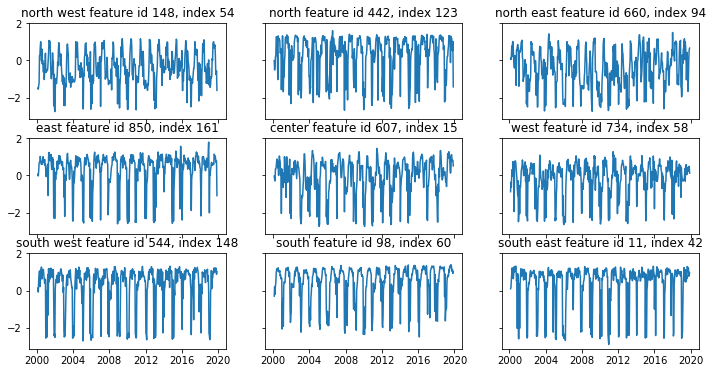

In [3]:
fid = 544
def plot(df, fid ,ax=None, title=""):
    idx = get_idx(df,fid)
    x = testdataset.data[idx][0,:,0]
    date = testdataset.date[idx][0,:].astype(np.datetime64)
    if ax is None:
        fig,ax = plt.subplots(figsize=(12,8))
    ax.plot(date,x)
    ax.set_title(f"{title} feature id {fid}, index {idx[0]}")
    
names = np.array([
    ["north west","north","north east"],
    ["east", "center", "west"],
    ["south west","south","south east"]
])

fids = np.array([
    [148, 442,660],
    [850, 607, 734],
    [544, 98, 11]
])

fig,axs = plt.subplots(3,3,figsize=(12,6),sharex=True,sharey=True)

for fid,name,ax in zip(fids.reshape(-1), names.reshape(-1), axs.reshape(-1)):
    print(fid,name,ax)
    plot(test,fid,ax=ax, title=name)
    

In [4]:
num_layers = 3
hidden_size = 32
region = "germany"
epoch = 10
model_name = f"LSTM_{region}_l={num_layers}_h={hidden_size}_e={epoch}.pth"
model_dir="/tmp/models/"

model_path=os.path.join(model_dir,model_name)
device = torch.device('cuda')

dataset = ModisDataset(region=region,
                            fold="test",
                            znormalize=True,
                            augment=False,
                            include_time=False,
                            smooth=None)

model = Model(input_size=1,
              hidden_size=hidden_size,
              num_layers=num_layers,
              output_size=1,
              device=device)

print(model_path)
restore(model_path,model)

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
/tmp/models/LSTM_germany_l=3_h=32_e=10.pth


148 north west AxesSubplot(0.125,0.657941;0.227941x0.222059)
54
442 north AxesSubplot(0.398529,0.657941;0.227941x0.222059)
123
660 north east AxesSubplot(0.672059,0.657941;0.227941x0.222059)
94
850 east AxesSubplot(0.125,0.391471;0.227941x0.222059)
161
607 center AxesSubplot(0.398529,0.391471;0.227941x0.222059)
15
734 west AxesSubplot(0.672059,0.391471;0.227941x0.222059)
58
544 south west AxesSubplot(0.125,0.125;0.227941x0.222059)
148
98 south AxesSubplot(0.398529,0.125;0.227941x0.222059)
60
11 south east AxesSubplot(0.672059,0.125;0.227941x0.222059)
42


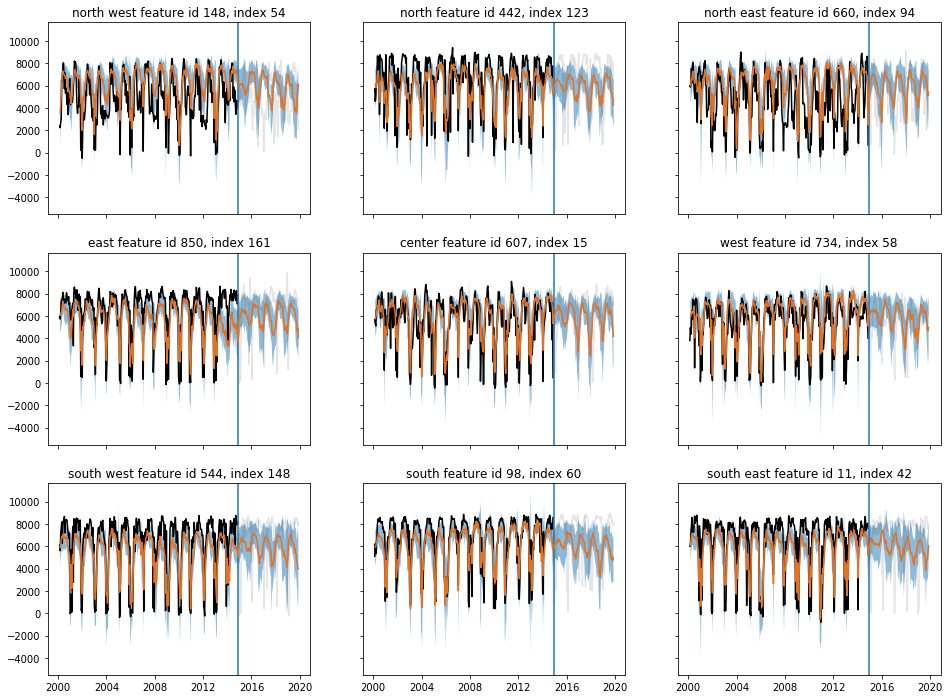

In [8]:

from visualizations import make_and_plot_predictions, make_and_plot_combined_predictions

def plot_model(testdataset,fid,ax, title):
    idx = get_idx(test,fid)[0]
    print(idx)
    N_seen_points = 340
    N_predictions=2

    x = testdataset.data[idx].astype(float)
    date = testdataset.date[idx].astype(np.datetime64)
    make_and_plot_combined_predictions(model, x, date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device, meanstd=(testdataset.mean,testdataset.std), ax=ax)
    
    ax.set_title(f"{title} feature id {fid}, index {idx}")

fig,axs = plt.subplots(3,3,figsize=(16,12),sharex=True,sharey=True)
for fid,name,ax in zip(fids.reshape(-1), names.reshape(-1), axs.reshape(-1)):
    print(fid,name,ax)
    plot_model(testdataset,fid,ax=ax, title=name)